# 📘 Phase 2: Spatial Data Handling and GIS Operations

## 🎯 Objectives
- **Vector Data Operations:** Reading, writing, and manipulating vector data using libraries like `geopandas`, `shapely`, and `fiona`.
- **Raster Data Operations:** Handling raster data with `rasterio`, including reading, writing, and performing basic analyses.
- **Coordinate Reference Systems (CRS):** Understanding and transforming between different CRSs using `pyproj`.
- **Spatial Operations:** Performing spatial joins, overlays, buffering, and other geospatial analyses.

## 🧰 Required Libraries
Ensure the following libraries are installed in your environment. They should already be present if you completed Phase 1.

In [1]:
import geopandas as gpd
import pandas as pd
import rasterio
from rasterio.plot import show
import fiona
from shapely.geometry import Point, Polygon
import pyproj
import matplotlib.pyplot as plt
import os # For file operations like checking existence and writing

## 🗺️ 1. Vector Data Operations with GeoPandas

### a. Reading Vector Data
We'll use the built-in Natural Earth dataset again.

World GeoDataFrame Head:
        featurecla  scalerank  LABELRANK                   SOVEREIGNT SOV_A3  \
0  Admin-0 country          1          6                         Fiji    FJI   
1  Admin-0 country          1          3  United Republic of Tanzania    TZA   
2  Admin-0 country          1          7               Western Sahara    SAH   
3  Admin-0 country          1          2                       Canada    CAN   
4  Admin-0 country          1          2     United States of America    US1   

   ADM0_DIF  LEVEL               TYPE TLC                        ADMIN  ...  \
0         0      2  Sovereign country   1                         Fiji  ...   
1         0      2  Sovereign country   1  United Republic of Tanzania  ...   
2         0      2      Indeterminate   1               Western Sahara  ...   
3         0      2  Sovereign country   1                       Canada  ...   
4         1      2            Country   1     United States of America  ...   

      FCLASS_TR    

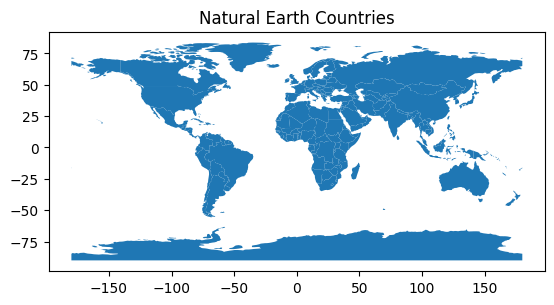

In [2]:
# Load a sample shapefile (e.g., world countries)
# This uses the same logic as Phase 1 to ensure the data is available
naturalearth_url = "https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip"
shapefile_zip = "ne_110m_admin_0_countries.zip"
shapefile_dir = "ne_110m_admin_0_countries"

import zipfile
import requests
import glob

if not os.path.exists(shapefile_dir):
    print("Downloading Natural Earth shapefile...")
    headers = {
        "User-Agent": "Mozilla/5.0",
        "Accept": "application/zip"
    }
    response = requests.get(naturalearth_url, headers=headers)
    if response.status_code == 200:
        with open(shapefile_zip, "wb") as f:
            f.write(response.content)
        print("Extracting shapefile...")
        with zipfile.ZipFile(shapefile_zip, "r") as zip_ref:
            zip_ref.extractall(shapefile_dir)
        print("Extraction complete.")
        # Clean up the zip file after extraction
        # os.remove(shapefile_zip) 
    else:
        raise Exception(f"Failed to download file. HTTP status code: {response.status_code}")

# Find the .shp file in the extracted directory
shp_files = glob.glob(os.path.join(shapefile_dir, "*.shp"))
if not shp_files:
    raise FileNotFoundError("No .shp file found in the extracted Natural Earth data.")
shapefile_path = shp_files[0]

world = gpd.read_file(shapefile_path)

print("World GeoDataFrame Head:")
print(world.head())

print("\nPlotting the loaded data:")
world.plot()
plt.title("Natural Earth Countries")
plt.show()

### b. Writing Vector Data
Saving a GeoDataFrame to a file format like Shapefile or GeoPackage.

In [4]:
# Define the output paths in the ../data directory (relative to the notebooks folder)
output_dir = "../data"
os.makedirs(output_dir, exist_ok=True)

output_shapefile = os.path.join(output_dir, "world_countries.shp")
output_geopackage = os.path.join(output_dir, "world_countries.gpkg")

# Save to a new shapefile
try:
    world.to_file(output_shapefile, driver='ESRI Shapefile')
    print(f"Successfully saved data to {output_shapefile}")
except Exception as e:
    print(f"Error saving to Shapefile: {e}")

# Save to GeoPackage
try:
    world.to_file(output_geopackage, driver='GPKG')
    print(f"Successfully saved data to {output_geopackage}")
except Exception as e:
    print(f"Error saving to GeoPackage: {e}")


f:\Python\notebooks\Projects\Geoscience_apps\.venv\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Value 328239523 of field POP_EST of feature 4 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
f:\Python\notebooks\Projects\Geoscience_apps\.venv\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Value 270625568 of field POP_EST of feature 8 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
f:\Python\notebooks\Projects\Geoscience_apps\.venv\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Value 144373535 of field POP_EST of feature 18 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
f:\Python\notebooks\Projects\Geoscience_apps\.venv\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Value 127575529 of field POP_EST of feature 27 not successfully written. Possibly due to too larger number with respect to field width
  o

Successfully saved data to ../data\world_countries.shp
Successfully saved data to ../data\world_countries.gpkg


### c. Creating Geometry Objects
Creating a GeoDataFrame programmatically from coordinates.

GeoDataFrame created from scratch:
       City  Latitude  Longitude                   geometry
0  New York   40.7128   -74.0060    POINT (-74.006 40.7128)
1    London   51.5074    -0.1278    POINT (-0.1278 51.5074)
2     Tokyo   35.6895   139.6917   POINT (139.6917 35.6895)
3    Sydney  -33.8688   151.2093  POINT (151.2093 -33.8688)
4     Cairo   30.0444    31.2357    POINT (31.2357 30.0444)

Plotting the created points:


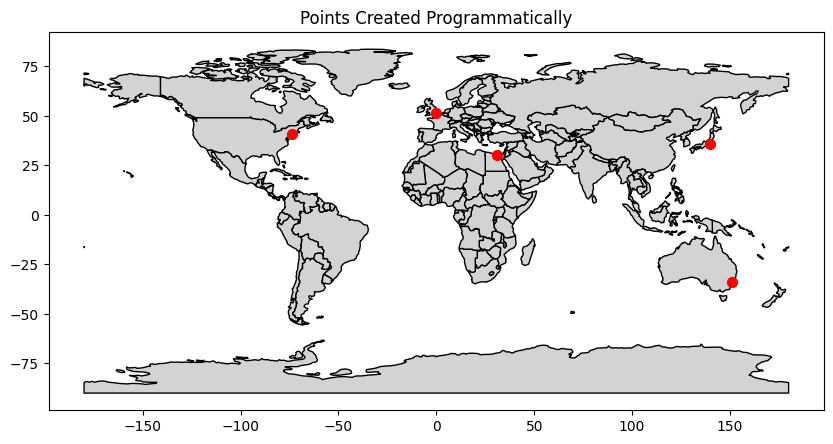

In [6]:
# Create a GeoDataFrame from scratch with Point geometries for major world cities
# Example: New York, London, Tokyo
points_data = {
    'City': ['New York', 'London', 'Tokyo', 'Sydney', 'Cairo'],
    'Latitude': [40.7128, 51.5074, 35.6895, -33.8688, 30.0444],
    'Longitude': [-74.0060, -0.1278, 139.6917, 151.2093, 31.2357]
}
df = pd.DataFrame(points_data)

# Create geometry objects from longitude and latitude
geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]

# Create the GeoDataFrame
# Specify the CRS - assuming WGS84 (latitude/longitude)
gdf_points = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

print("GeoDataFrame created from scratch:")
print(gdf_points.head())

print("\nPlotting the created points:")
# Plotting requires a basemap for context
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
world.plot(ax=ax, color='lightgrey', edgecolor='black') # Use world map as basemap
gdf_points.plot(ax=ax, marker='o', color='red', markersize=50) # Plot points on top
plt.title("Points Created Programmatically")
plt.show()

## 🌐 2. Coordinate Reference Systems (CRS)
Understanding and managing CRS is fundamental in GIS.

### a. Checking CRS
Every GeoDataFrame should have a CRS defined.

In [7]:
# Check the current CRS of the world GeoDataFrame
print("CRS of the 'world' GeoDataFrame:")
print(world.crs)

# Check the CRS of the points we created
print("\nCRS of the 'gdf_points' GeoDataFrame:")
print(gdf_points.crs)

CRS of the 'world' GeoDataFrame:
EPSG:4326

CRS of the 'gdf_points' GeoDataFrame:
EPSG:4326


### b. Reprojecting Data
Transforming data from one CRS to another. This is crucial when performing operations that require data to be in the same projection (e.g., spatial joins, overlays, distance calculations).

Reprojecting 'world' GeoDataFrame to EPSG:32633...
Reprojection successful.
New CRS: EPSG:32633

Plotting reprojected data (UTM Zone 33N):


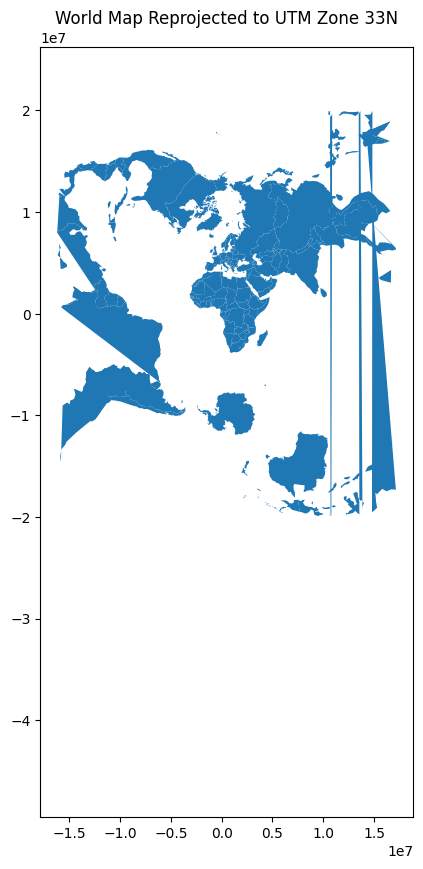


Reprojecting 'gdf_points' GeoDataFrame to EPSG:32633...
Reprojection successful.
New CRS: EPSG:32633


In [8]:
# Reproject the world data to UTM zone 33N (EPSG:32633)
# This projection is suitable for parts of Europe/Africa
target_crs = "EPSG:32633" 
print(f"Reprojecting 'world' GeoDataFrame to {target_crs}...")
try:
    world_utm = world.to_crs(epsg=32633) # Can use epsg= code directly
    # Alternatively: world_utm = world.to_crs(target_crs)
    print("Reprojection successful.")
    print(f"New CRS: {world_utm.crs}")

    # Plot the reprojected data
    print("\nPlotting reprojected data (UTM Zone 33N):")
    world_utm.plot(figsize=(10, 10))
    plt.title("World Map Reprojected to UTM Zone 33N")
    plt.show()
except Exception as e:
    print(f"An error occurred during reprojection: {e}")

# Reproject our points to the same UTM zone
print(f"\nReprojecting 'gdf_points' GeoDataFrame to {target_crs}...")
try:
    gdf_points_utm = gdf_points.to_crs(world_utm.crs) # Use the CRS from world_utm
    print("Reprojection successful.")
    print(f"New CRS: {gdf_points_utm.crs}")
except Exception as e:
    print(f"An error occurred during reprojection: {e}")

## 🗺️ 3. Raster Data Operations with Rasterio
Working with grid-based data like satellite imagery or elevation models.

### a. Reading Raster Data
Opening and reading data from a raster file (e.g., GeoTIFF).

Attempting to read raster data from: https://copernicus-dem-30m.s3.amazonaws.com/Copernicus_DSM_COG_10_N00_00_E006_00_DEM/Copernicus_DSM_COG_10_N00_00_E006_00_DEM.tif
Raster file opened successfully.
CRS: EPSG:4326
Bounds: BoundingBox(left=5.9998611111111115, bottom=0.0001388888888889106, right=6.9998611111111115, top=1.000138888888889)
Resolution: (0.0002777777777777778, 0.0002777777777777778)
Number of bands: 1

Plotting raster data (Band 1):


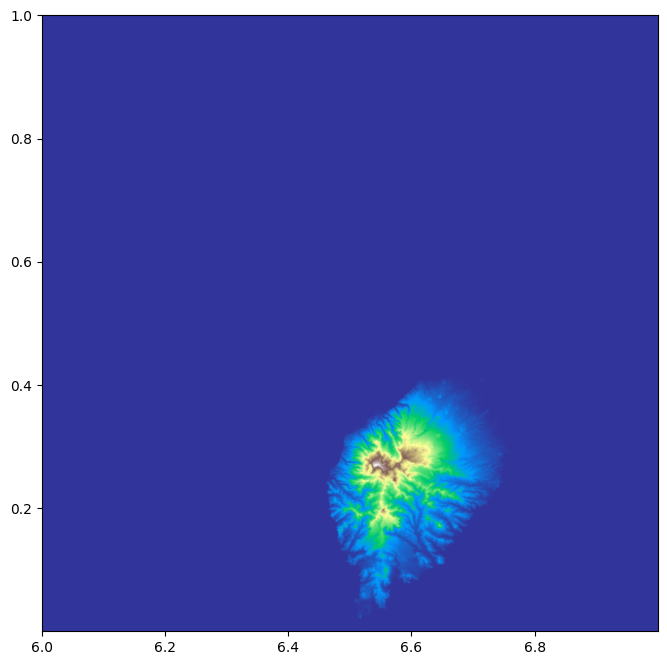

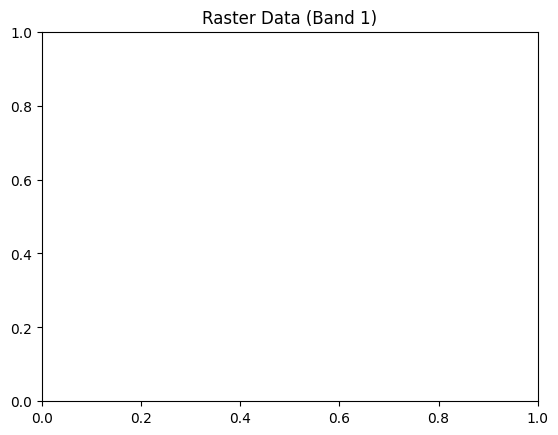

In [11]:
# IMPORTANT: Replace 'path_to_raster.tif' with an actual path to a GeoTIFF file on your system.
# You could reuse the Copernicus DEM link from Phase 1 if needed:
raster_path = "https://copernicus-dem-30m.s3.amazonaws.com/Copernicus_DSM_COG_10_N00_00_E006_00_DEM/Copernicus_DSM_COG_10_N00_00_E006_00_DEM.tif"
#raster_path = 'path_to_raster.tif' 

print(f"Attempting to read raster data from: {raster_path}")

# Check if the placeholder path was replaced
if raster_path == 'path_to_raster.tif':
    print("\nWarning: Please replace 'path_to_raster.tif' with a valid file path or URL.")
else:
    try:
        # Use rasterio.Env() for better environment management, especially with cloud sources
        with rasterio.Env():
            with rasterio.open(raster_path) as src:
                print("Raster file opened successfully.")
                print(f"CRS: {src.crs}")
                print(f"Bounds: {src.bounds}")
                print(f"Resolution: {src.res}")
                print(f"Number of bands: {src.count}")
                
                # Read the first band
                raster_band1 = src.read(1)
                
                # Store metadata for writing later
                raster_meta = src.meta.copy() 
                
                # Plot the raster data
                print("\nPlotting raster data (Band 1):")
                plt.figure(figsize=(8, 8))
                show(raster_band1, cmap='terrain', transform=src.transform) # Use show from rasterio.plot
                plt.title('Raster Data (Band 1)')
                # Adding a colorbar requires a bit more setup with rasterio's show
                # fig, ax = plt.subplots(1, 1, figsize=(8, 8))
                # image_hidden = ax.imshow(raster_band1, cmap='terrain')
                # show(raster_band1, ax=ax, transform=src.transform, cmap='terrain')
                # fig.colorbar(image_hidden, ax=ax)
                # ax.set_title('Raster Data (Band 1)')
                plt.show()

    except rasterio.RasterioIOError as e:
        print(f"\nError opening or reading raster file: {e}")
        print("Please ensure the path is correct and the file is accessible.")
    except Exception as e:
        print(f"\nAn unexpected error occurred: {e}")

### b. Writing Raster Data
Saving modified or newly created raster data.

In [12]:
# Write the raster to the ../data directory
output_raster_path = os.path.join(output_dir, 'new_raster.tif')

if 'raster_band1' in locals() and 'raster_meta' in locals():
    print(f"Attempting to write raster data to: {output_raster_path}")
    try:
        with rasterio.open(output_raster_path, 'w', **raster_meta) as dst:
            dst.write(raster_band1, 1)
        print(f"Successfully wrote raster data to {output_raster_path}")
    except Exception as e:
        print(f"\nError writing raster file: {e}")
else:
    print("\nSkipping raster writing: 'raster_band1' or 'raster_meta' not found.")
    print("Please ensure the previous cell (reading raster data) ran successfully.")


Attempting to write raster data to: ../data\new_raster.tif
Successfully wrote raster data to ../data\new_raster.tif


## 🔄 4. Spatial Operations
Performing analysis based on the spatial relationships between geometries.

### a. Buffering
Creating a polygon around existing geometries at a specified distance. Buffering often requires data to be in a projected CRS (like UTM) for distances to be meaningful in meters or feet.

C:\Users\mharsalan\AppData\Local\Temp\ipykernel_56240\1530129817.py:23: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


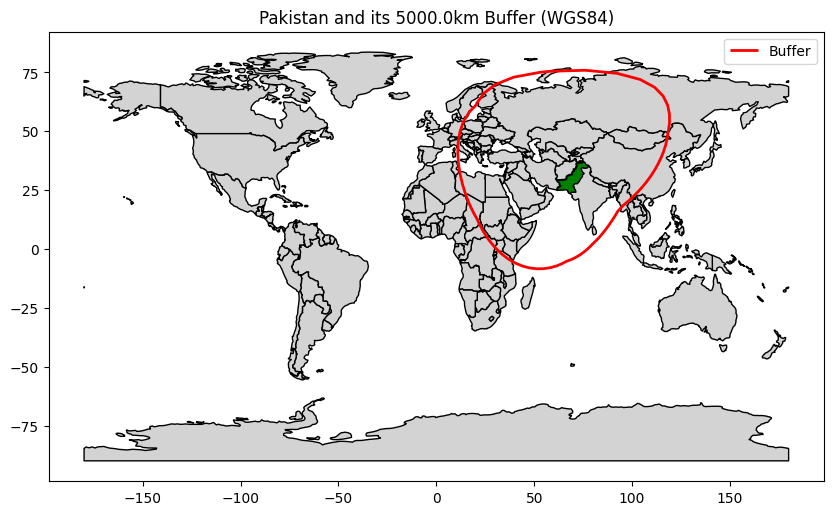

In [22]:
buffer_distance = 5000000  # Buffer distance in meters (5000 km)
# Ensure 'world' is in WGS84
if world.crs != "EPSG:4326":
    world = world.to_crs("EPSG:4326")

# Subset Pakistan from world (WGS84)
pakistan = world[world['ADMIN'] == 'Pakistan']

if not pakistan.empty:
    # Reproject Pakistan to UTM
    pakistan_utm = pakistan.to_crs("EPSG:32633")
    # Create buffer in UTM (meters)
    pakistan_utm = pakistan_utm.copy()
    pakistan_utm['buffered_geom'] = pakistan_utm.geometry.buffer(buffer_distance)
    # Convert buffer back to WGS84
    buffer_wgs84 = pakistan_utm.set_geometry('buffered_geom').to_crs("EPSG:4326")
    # Plot
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    world.plot(ax=ax, color='lightgrey', edgecolor='black')
    pakistan.plot(ax=ax, color='green', edgecolor='black', label='Pakistan')
    buffer_wgs84.boundary.plot(ax=ax, color='red', linewidth=2, label='Buffer')
    ax.set_title(f"Pakistan and its {buffer_distance/1000}km Buffer (WGS84)")
    ax.legend()
    plt.show()
else:
    print("Pakistan not found in the dataset.")


### b. Spatial Join
Combining attributes from two GeoDataFrames based on their spatial relationship (e.g., points within polygons). Both GeoDataFrames must have the same CRS.

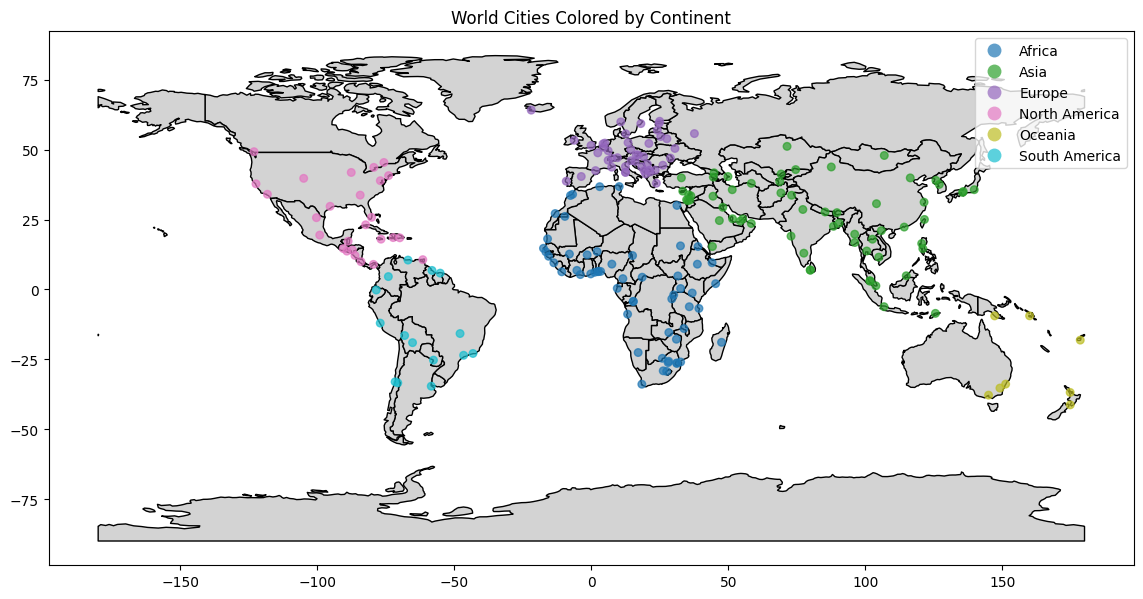

In [30]:
# Spatial join: assign each city to its country
if cities_gdf.crs != world.crs:
    cities_gdf = cities_gdf.to_crs(world.crs)

cities_with_country = gpd.sjoin(cities_gdf, world, how="inner", predicate="within")

# Check available columns to find the correct continent column name
# print(cities_with_country.columns)  # Uncomment to inspect columns if needed

# Use the correct column name for continent (likely 'CONTINENT' or 'CONTINENT_right')
continent_col = None
for col in cities_with_country.columns:
    if col.lower() == "continent" or col.lower().endswith("_continent") or "continent" in col.lower():
        continent_col = col
        break

if continent_col is None:
    raise KeyError("No continent column found in the joined GeoDataFrame.")

# Plot: world countries and cities, colored by continent
fig, ax = plt.subplots(figsize=(14, 8))
world.plot(ax=ax, color="lightgrey", edgecolor="black")
cities_with_country.plot(ax=ax, column=continent_col, markersize=30, legend=True, alpha=0.7)
ax.set_title("World Cities Colored by Continent")
plt.show()


## 📌 Summary
In this phase, we've:

- Explored vector data operations (reading, writing, creating) using `GeoPandas`.
- Manipulated raster data (reading, writing) with `Rasterio`.
- Understood the importance of Coordinate Reference Systems (CRS) and performed reprojections.
- Executed basic spatial operations like buffering vector data and performing spatial joins between point and polygon layers.

## 🔗 Additional Resources
- [GeoPandas Documentation](https://geopandas.org/en/stable/)
- [Rasterio Documentation](https://rasterio.readthedocs.io/en/stable/)
- [Shapely Documentation](https://shapely.readthedocs.io/en/stable/)
- [PyProj Documentation](https://pyproj4.github.io/pyproj/stable/)